## 1. Packages

In [3]:
''' root '''
import os
os.chdir("..")
print("Current Working Directory:", os.getcwd())

import sys
sys.path.append(os.getcwd())

''' config '''
from configparser import ConfigParser
config = ConfigParser()
config.read("config/config.ini")
print("Config Sections:", config.sections())
args = config["graph_models"]

Current Working Directory: /Users/garyliu/Documents/Cathay
Config Sections: ['text_cleaning', 'feature_engineering', 'graph_models']


In [7]:
param_test = args["use_cuda"]

'1'

In [9]:
import argparse
param_test = argparse.Namespace(**args)

In [12]:
param_test

Namespace(data_path='dataset/processed_dataset/', modeling_feature_path='dataset/full_dataset/modeling_features.json', partial_feature_path='dataset/full_dataset/partial_features.json', result='result/', set_seed='123', use_cuda='1')

In [2]:
''' packages '''
# 1. models
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.data import InMemoryDataset, Dataset, download_url
from torch.utils.data import random_split
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 2. others
from tqdm import tqdm_notebook as tqdm
import multiprocessing as mp
import argparse
import pandas as pd, numpy as np
import time
import pickle
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("logs/graph/")

# 3. custom
from src.preprocessing.feature_engineering.bert_embedding import BertEmbedding
from src.utils.vocabulary import Vocabulary
from src.utils.pipeline import Pipe

## 2.1. Initial Variables & Parameters

In [3]:
''' Hyperparameters '''
parser = {
    "batch_size": 64,
    "seed": 5, # random seed
    "epochs": 10,
    "cuda": True, # use cuda or not
    "log_every": 50,
    "lr": 0.05,  # initial learning rate
    "lr_decay": 0.7,  # decay lr when not observing improvement in val_loss
    "lr_min": 1e-5,  # stop when lr is too low
    "n_bad_loss": 4,  # number of bad val_loss before decaying
    "result_path": "result/graph/",  # path to save models
    "log_path": "logs/graph/",
}
config = argparse.Namespace(**parser)

In [4]:
''' General '''
config.USE_CUDA = bool(int(args["use_cuda"]))
config.SEED = int(args["set_seed"])
config.MODELING_FEATURE_PATH = args["partial_feature_path"]
config.DATA_PATH = args["data_path"]
config.NUM_FEATURES = 768
config.N_CLASSES = 1
config.TARGET = "overall"
config.EDGE_INDEX = "edgeIndex3"
config.NODES = "uniqueTokens"

## 2.2. CUDA Settings

In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config.USE_CUDA = config.USE_CUDA and torch.cuda.is_available()
print("cuda on: ", config.USE_CUDA)
if config.USE_CUDA:
    torch.cuda.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
else:
    torch.manual_seed(config.SEED)
    
device = torch.device("cuda:0" if config.USE_CUDA else "cpu")

cuda on:  True


In [6]:
def seed_torch(seed=config.SEED):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## 3-0. Data

In [7]:
print("read the datasets...")
files = []
# file_path = [file for file in os.listdir(config.DATA_PATH) if file.endswith(".json")]
file_path = ['Video_Games_5.json', 'Musical_Instruments_5.json']
for file in file_path:    
    files.append(pd.read_json(os.path.join(config.DATA_PATH, file)))
    
df = pd.concat(files)

read the datasets...


In [8]:
df.shape

(727329, 7)

## 3-1. Exploration

Let's take a look at the distribution of word count (by overall).

### 3-1-1. Review Count vs. Unique Review Count

In [9]:
def token_statistics(tokens):
    print("max:", max(tokens))
    print("min:", min(tokens))
    print("median:", np.median(tokens))
    print("mean:", np.mean(tokens))
    print("Q3:", np.quantile(tokens, 0.75))
    print("Q1:", np.quantile(tokens, 0.25))
    print("Q(90%):", np.quantile(tokens, 0.9))
    return

In [10]:
review_count = [len(row) for row in df["reviewTokens"]]
unique_count = [len(row) for row in df["uniqueTokens"]]

print("=== Review Count ===")
token_statistics(review_count)

print("\n=== Unique Review Count ===")
token_statistics(unique_count)

=== Review Count ===
max: 3075
min: 1
median: 18.0
mean: 52.301840020128445
Q3: 52.0
Q1: 6.0
Q(90%): 134.0

=== Unique Review Count ===
max: 1233
min: 1
median: 16.0
mean: 37.81206854119662
Q3: 43.0
Q1: 6.0
Q(90%): 98.0


### 3-1-2. Overall vs.  Tokens

Median Review Tokens in Overall 1: 30.0
Median Review Tokens in Overall 2: 40.0
Median Review Tokens in Overall 3: 34.0
Median Review Tokens in Overall 4: 29.0
Median Review Tokens in Overall 5: 13.0


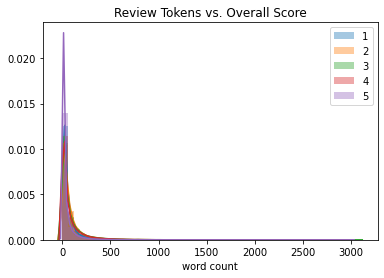

In [11]:
for i in range(1, 6):
    subdf = df[df["overall"] == i]
    sub_word_len = [len(row) for row in subdf["reviewTokens"]]
    print("Median Review Tokens in Overall {}: {}".format(i, np.median(sub_word_len)))
    sns.distplot(sub_word_len, hist=True)
    plt.legend(range(1, 6))
    plt.xlabel("word count")
    plt.title("Review Tokens vs. Overall Score")

Median Unique Tokens in Overall 1: 26.0
Median Unique Tokens in Overall 2: 34.0
Median Unique Tokens in Overall 3: 29.0
Median Unique Tokens in Overall 4: 25.0
Median Unique Tokens in Overall 5: 12.0


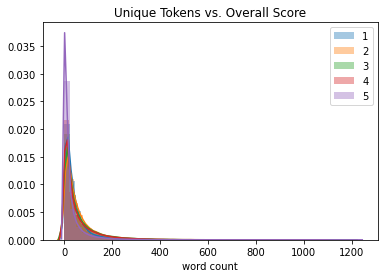

In [12]:
for i in range(1, 6):
    subdf = df[df["overall"] == i]
    sub_word_len = [len(row) for row in subdf["uniqueTokens"]]
    print("Median Unique Tokens in Overall {}: {}".format(i, np.median(sub_word_len)))
    sns.distplot(sub_word_len, hist=True)
    plt.legend(range(1, 6))
    plt.xlabel("word count")
    plt.title("Unique Tokens vs. Overall Score")

### 3-1-3. Label Count

Let's take a look at the number of sample in each label (overall).

<AxesSubplot:xlabel='overall', ylabel='count'>

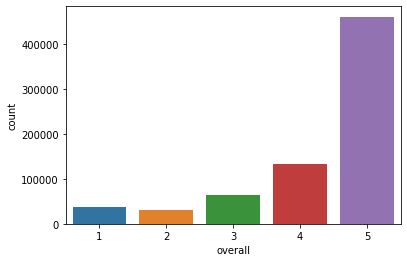

In [13]:
sns.countplot(x = 'overall', data=df)

## 3-2. Review Score to Positive/Negative

In [14]:
def reclassify(df, target="overall"):
    '''
    1. score 3 & 4 & 5 -> 1 (positive)
    2. score 1 & 2 -> 0 (negative)
    '''
    y = []
    for gp in df[target]:
        if gp in [3, 4, 5]:
            y.append(1)
        elif gp in [1, 2]:
            y.append(0)
    assert len(y) == df.shape[0]
    
    return y

In [15]:
df["y"] = reclassify(df, "overall")
config.TARGET = "y" # this will be used to set up model pipeline so that I won't have to change the target name quite often.

In [16]:
# check if there is no strange value among the target variable
assert sum(df[config.TARGET].isna()) == 0

## 3-3. Train Test Split

In [17]:
def dataset_split(df, train_percent=0.8, val_percent=0.1, set_seed=123):
    n = df.shape[0] # get length of dataframe

    # I will set the percentage of validation and test sets to be both 0.1
    train_index, rest_index = train_test_split(range(n), train_size=train_percent, random_state=set_seed)
    val_index, test_index = train_test_split(rest_index, train_size=(val_percent/(1-train_percent)), random_state=set_seed) # 0.1/(1-0.8) = 0.1/0.2 = 0.5

    # check if there is any intersection among all three sets
    assert len(set(train_index + val_index + test_index)) == n

    # get sub_datasets by random_split
    np.random.seed(set_seed)
    train_df, val_df, test_df = df.iloc[train_index, :].reset_index(drop=True),\
                                df.iloc[val_index, :].reset_index(drop=True),\
                                df.iloc[test_index, :].reset_index(drop=True)

    # check random_split works correctly
    assert (len(train_df)+len(val_df)+len(test_df)) == n
    
    return train_df, val_df, test_df

In [18]:
train_df, val_df, test_df = dataset_split(df)

Text(0, 0.5, 'Count')

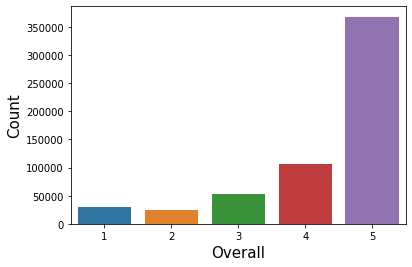

In [22]:
sns.countplot(x = 'overall', data=train_df)
plt.xlabel("Overall", fontsize=15)
plt.ylabel("Count", fontsize=15)

## 3-4. Build Vocabulary

It's reasonable to build a vocabulary list from only the training set.

In [19]:
vocabulary = Vocabulary()

for row in train_df[config.NODES]:
    for word in row:
        vocabulary.add_word(word)

## 3-5. Imbalanced Dataset

Note: I only make the training set balanced and leave the validation and test sets alone.

Text(0, 0.5, 'Count')

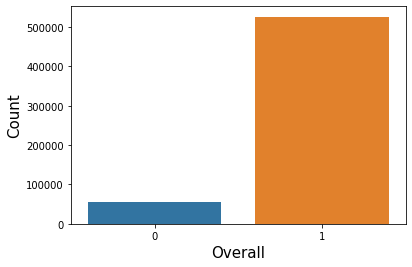

In [23]:
# plot the imbalanced target variable
sns.countplot(train_df[config.TARGET])
plt.xlabel("Overall", fontsize=15)
plt.ylabel("Count", fontsize=15)

In [24]:
# undersampling
def undersampling(df, target=config.TARGET, set_seed=config.SEED):
    np.random.seed(set_seed)
    df = df.groupby(target)
    df = df.apply(lambda x: x.sample(df.size().min())).sample(frac=1).reset_index(drop=True)
    return df

In [25]:
train_df = undersampling(train_df)
print("Length of training set:", train_df.shape[0])
print("Length of test set:", test_df.shape[0])

Length of training set: 111520
Length of test set: 72733


Text(0, 0.5, 'Count')

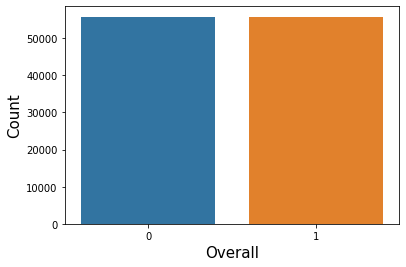

In [26]:
sns.countplot(train_df[config.TARGET])
plt.xlabel("Overall", fontsize=15)
plt.ylabel("Count", fontsize=15)

## 4-1. Dataset

In [21]:
''' Use this one if you don't want to output/save the graph data. '''
class GraphDataset(Dataset):
    def __init__(self, config, root, df, vocabulary, use_cuda, embedd_mode="random", transform=None, pre_transform=None):
        self.root = root
        self.voc = vocabulary
        self.df = df.copy()
        self.use_cuda = use_cuda
        
        assert embedd_mode in ["random", "bert"] # I only provide a text transformed dataset for random and bert embeddings
        if embedd_mode == "random":
            df[config.NODES] = [self.words_to_indices(row) for row in df[config.NODES]] # transform text to index first to make the model faster
#             embedding = nn.Embedding(self.voc.num_words, config.NUM_FEATURES) # use nn.Embedding to create random word embeddings
#             pipe = Pipe([torch.tensor, embedding]) # build a pipeline for creating random embedding
#             self.build_embeddings = pipe.call_pipeline
        elif embedd_mode == "bert":
            bertembedding = BertEmbedding()
            pipe = Pipe([bertembedding.get_embeddings, torch.tensor])
            self.build_embeddings = pipe.call_pipeline
        self.embedd_mode = embedd_mode
            
        super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        pass

    def len(self):
        return self.df.shape[0]

    def get(self, idx):
        return self.build_data(idx)
    
    def build_data(self, idx):
        tt = torch.cuda if self.use_cuda else torch
        if self.embedd_mode == "random":
            x = self.df[config.NODES][idx] # I will do pretrained in forward since the weights are learnable
        elif self.embedd_mode == "bert":
            x = self.build_embeddings(self.df[config.NODES][idx]).float().to(device) # build embedding matrix from "texts"
        edge_index = tt.LongTensor(self.df[config.EDGE_INDEX][idx]) # "config.EDGE_INDEX == edgeIndex"
        y = tt.FloatTensor([self.df[config.TARGET][idx]]) ## config.TARGET == "y" or "overall"
        data = Data(x=x, edge_index=edge_index, y=y)
        return data
    
    def words_to_indices(self, words):
        '''
        This function turns words to indices from Vocabulary list and returns a tensor of indices.
        
        @ param words: a list of words
        '''
        return [self.voc.get_index(w) for w in words]
            

In [22]:
def get_datasets(config, root, vocabulary, use_cuda, embedd_mode, train_df=train_df, val_df=val_df, test_df=test_df):
    datasets = []
    for data in [train_df, val_df, test_df]:
        datasets.append(GraphDataset(config, root, data, vocabulary, use_cuda, embedd_mode))
    return datasets

In [23]:
# config.NUM_FEATURES = 128
train_dataset, val_dataset, test_dataset = get_datasets(config,
                                                        root=config.DATA_PATH, # "/home/kll482/cathay/dataset",
                                                        vocabulary=vocabulary,
                                                        use_cuda=config.USE_CUDA,
                                                        embedd_mode="bert",
                                                        train_df=train_df,
                                                        val_df=val_df,
                                                        test_df=test_df,
                                                       )

In [24]:
# check if the row length remains the same even we transform dataframe into graph dataset
assert len(train_dataset)+len(val_dataset)+len(test_dataset) == len(train_df)+len(val_df)+len(test_df)

## 4-2. DataLoader

In [25]:
# ''' Get dataloaders subsets from the whole dataset. '''
# def get_dataloaders(config, dataset, train_percent=0.8, val_percent=0.1):

#     # get length of subsets
#     train_len = int(dataset.len()*0.8)
#     val_len = int(dataset.len()*0.1)
#     test_len = dataset.len()-train_len-val_len
    
#     # get sub_datasets by random_split
#     seed_torch(config.SEED)
#     train_dataset, val_dataset, test_dataset = random_split(dataset, (train_len, val_len, test_len))
    
#     # check random_split works correctly
#     assert (len(train_dataset)+len(val_dataset)+len(test_dataset)) == dataset.len()
    
#     # get dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
#     test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    
#     return train_loader, val_loader, test_loader

# train_loader, val_loader, test_loader = get_dataloaders(config, dataset, train_percent=0.8, val_percent=0.1)

In [26]:
seed_torch(config.SEED)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## 5. Architecture

In [27]:
# ref: https://colab.research.google.com/drive/1DIQm9rOx2mT1bZETEeVUThxcrP1RKqAn
# GCN for binary classification
class BinGCNConv(torch.nn.Module):
    def __init__(self, embedding_size, n_classes=1, drop=0, task="graph"):
        super(BinGCNConv, self).__init__()
        self.conv1 = GCNConv(embedding_size, 128, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.conv2 = GCNConv(128, 64, cached=False)
        self.ln1 = nn.LayerNorm(128)
        self.ln2 = nn.LayerNorm(64)
        self.linear = nn.Linear(64, 64)
        self.classify = nn.Linear(64, n_classes)
        self.task = task
        self.drop = drop
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = self.ln1(x)
        
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = self.ln2(x)
        
        # to make a graph-level classification, I need a output size of (total # of graph in a batch) * n_classes
        # therefore, I take the mean of nodes in one GRAPH to represent it output
        if self.task == 'graph':
            x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = self.classify(x) # size: (total # of nodes in a batch) * n_classes
        return x.squeeze(-1) # use nn.BCEWithLogitsLoss during training

In [28]:
# ref: https://colab.research.google.com/drive/1DIQm9rOx2mT1bZETEeVUThxcrP1RKqAn
# GATConv for binary classification
class BinGATConv(torch.nn.Module):
    def __init__(self, embedding_size, n_classes=1, drop=0, task="graph"):
        super(BinGATConv, self).__init__()
        self.conv1 = GATConv(embedding_size, 128, heads=1, dropout=drop) # if you defined cache=True, the shape of batch must be same!
        self.conv2 = GATConv(128, 64, heads=1, dropout=drop)
        self.ln1 = nn.LayerNorm(128)
        self.ln2 = nn.LayerNorm(64)
        self.linear = nn.Linear(64, 64)
        self.classify = nn.Linear(64, n_classes)
        self.task = task
        self.drop = drop
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = self.ln1(x)
        
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = self.ln2(x)
        
        # to make a graph-level classification, I need a output size of (total # of graph in a batch) * n_classes
        # therefore, I take the mean of nodes in one GRAPH to represent it output
        if self.task == 'graph':
            x = global_mean_pool(x, batch)
        else:
            pass
        x = self.linear(x)
        x = self.classify(x) # size: (total # of nodes in a batch) * n_classes
        return x.squeeze(-1) # use nn.BCEWithLogitsLoss during training

## 6. Train & Validation & Test Functions

In [29]:
def adjust_learning_rate(optimizer, lr_decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay

In [30]:
def write_log(text, file_path, mode="a+"):
    print(text)
    with open(file_path, mode) as file:
        file.write(text+"\n")

In [31]:
def write_config(config):
    texts = "=== Settings ===\n"
    var_config = vars(config)
    for i in range(len(var_config)):
        temp_text = "{}: {}\n".format(list(var_config.keys())[i],
                                      list(var_config.values())[i],
                                     )
        texts += temp_text
    texts += "============\n\n"
    return texts

In [32]:
def train(config, train_loader, val_loader, model, criterion, optimizer):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    logs = "=> EPOCH {}".format(epoch)
    write_log(logs, config.log_file, "a+")
    
    for batch_index, batch in tqdm(enumerate(train_loader)):
        iteration += 1 # total iteration within all batches
        
        batch = batch.to(device)
        
        if config.N_CLASSES == 1:
            # binary
            label = batch.y.float()
        elif config.N_CLASSES > 1:
            label = batch.y.long()
        label = label.to(device).detach()
        
        # train the model
        model.train()
#         for param in model.parameters():
#             print(param.requires_grad)
        output = model(batch)
        
        # loss function
        loss = criterion(output, label)
        
        # BP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # sum with the previous training loss for updating learning rate in the following
        train_loss += batch.num_graphs * loss.item() # accumulated training loss; batch.num_graphs is the size of the batch
        n_total += batch.num_graphs
        
#         # validation check 
        if iteration % config.log_every == 0:
            train_loss /= n_total 
            val_loss = validate(config, val_loader, model, criterion)
        
            # save logs
            logs = "   % Time: {} | Iteration: {:5} | Batch: {:4}/{}"\
                  " | Train loss: {:.4f} | Val loss: {:.4f}"\
                  .format(str(datetime.now()-init), iteration, batch_index+1,
                          len(train_loader), train_loss, val_loss)
            write_log(logs, config.log_file, "a+")

            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss: # update the best validation loss
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), config.best_model) # save the checkpoint
            else:
                n_bad_loss += 1
            
            # update the learning rate if val loss does not improve for n_bad_loss times
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                
                logs = "=> Adjust learning rate to: {}".format(new_lr)
                write_log(logs, config.log_file, "a+")
                
                if new_lr < config.lr_min:
                    stop = True
                    break


In [33]:
def validate(config, val_loader, model, criterion):
#     for param in model.parameters():
#         param.requires_grad = False
        
    model.eval()
    val_loss = 0
    dataset_size = 0
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        
        if config.N_CLASSES == 1:
            # binary
            label = batch.y.float()
        elif config.N_CLASSES > 1:
            label = batch.y.long()
            
        label = label.to(device)
        dataset_size += batch.num_graphs
        
        # train the model
        output = model(batch)
        loss = criterion(output, label)
        val_loss += loss.data * batch.num_graphs
    return val_loss / dataset_size

In [34]:
def test(config, test_loader, model, threshold=0.5):
    print("start testing...")
#     for param in model.parameters():
#         param.requires_grad = False
        
    model.eval()
    dataset_size = 0
    label_list = []
    prediction_list = []
    predict_prob_list = []
    
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        
        if config.N_CLASSES > 1:
            label = batch.y.long()
            label = label.data.tolist()
            label_list += label
            output = model(batch)
            _, prediction = torch.max(output, 1)
            prediction = prediction.data.tolist()
            prediction_list += prediction
            
        elif config.N_CLASSES == 1:
            # binary
            label = batch.y.float()            
            label = label.data.tolist()
            label_list += label
            output = model(batch)
            sigmoid = nn.Sigmoid() 
            output = sigmoid(output) # [-inf, inf] -> [0, 1]
            prediction_list += [1 if o > threshold else 0 for o in output.data.tolist()]
            predict_prob_list += output.data.tolist()
        
    confusion_matrix_df = pd.DataFrame(confusion_matrix(label_list, prediction_list))#.rename(columns=["1","2","3","4","5"], index=["1","2","3","4","5"])
    # write the confusion matrix into the log
    write_log("\n{}\n\n{}\n".\
          format("=== Confusion Matrix ===",
                 confusion_matrix_df
                 
                ),
          config.log_file,
          "a+")
    
    sns.heatmap(confusion_matrix_df, annot=True)
    
    return label_list, prediction_list, predict_prob_list

In [35]:
def model_load(config, model_test, name):
    if name is None:
        model_reloaded = config.best_model
    else:
        model_reloaded = os.path.join(config.result_path, "checkpoint/{}.pth".format(name))
    model_train = torch.load(model_reloaded)
#     model_test = BinGATConv(config.NUM_FEATURES, config.N_CLASSES).to(device)
    model_test.load_state_dict(model_train)

    return model_test

## 7. Training

In [ ]:
for neighbor in [5]:
    ''' initials '''
    # seed_torch(config.SEED)
    seed_torch(config.SEED)
    config.N_CLASSES = 1
    config.EDGE_INDEX = "edgeIndex{}".format(str(neighbor))
    model_name = "GAT"
    
    ''' rebuild dataset and dataloader due to edge_index '''
    train_dataset, val_dataset, test_dataset = get_datasets(config,
                                                        root=config.DATA_PATH, # "/home/kll482/cathay/dataset",
                                                        vocabulary=vocabulary,
                                                        use_cuda=config.USE_CUDA,
                                                        embedd_mode="bert",
                                                        train_df=train_df,
                                                        val_df=val_df,
                                                        test_df=test_df,
                                                       )
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
    
    ''' initializing the model '''
    model = BinGATConv(config.NUM_FEATURES, config.N_CLASSES, drop=0).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)

    # MultiClass
    # model = MultiClassNet(config.NUM_FEATURES, config.N_CLASSES).to(device)
    # criterion = nn.NLLLoss().to(device)

    optimizer = optim.Adagrad(model.parameters(), lr=config.lr)

    config.best_model = os.path.join(config.result_path, "checkpoint/neighbor{}_{}_{}.pth".format(neighbor,
                                                                                                 model_name,
                                                                                                 datetime.now().strftime("%Y_%m_%d_%H_%M")
                                                                                                )
                                    )
    config.log_file = os.path.join(config.log_path, "neighbor{}_{}_{}.txt".format(neighbor,
                                                                                  model_name,
                                                                                  datetime.now().strftime("%Y_%m_%d_%H_%M")
                                                                                   )
                                  )
    ''' start training '''
    saved = True
    if 1 == 1:  # change to True to train
        iteration = n_total = train_loss = n_bad_loss = 0
        stop = False
        best_val_loss = float("inf")
        init = datetime.now()
        config.epochs = 20
        config.log_every = 500
        config.lr = 0.01
    #     config.n_bad_loss 4

        if saved:
            output_text = write_config(config) + "Start record at {}\n".format(str(datetime.now()))
            write_log(output_text,
                      config.log_file,
                      "w+")

        for epoch in range(1, config.epochs+1):
            train(config, train_loader, val_loader, model, criterion, optimizer)
            if stop:
                break

=== Settings ===
batch_size: 64
seed: 5
epochs: 20
cuda: True
log_every: 500
lr: 0.01
lr_decay: 0.7
lr_min: 1e-05
n_bad_loss: 4
result_path: result/graph/
log_path: logs/graph/
USE_CUDA: True
SEED: 123
MODELING_FEATURE_PATH: dataset/full_dataset/partial_features.json
DATA_PATH: dataset/processed_dataset/
NUM_FEATURES: 768
N_CLASSES: 1
TARGET: y
EDGE_INDEX: edgeIndex5
NODES: uniqueTokens
best_model: result/graph/checkpoint/neighbor5_GAT_2020_08_23_12_06.pth
log_file: logs/graph/neighbor5_GAT_2020_08_23_12_06.txt
PREDICTED_RESULT: result/graph/prediction/neighbor3_GAT_2020_08_22_14_24_version2.pkl

Start record at 2020-08-23 12:06:09.467162

=> EPOCH 1


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



   % Time: 0:06:38.866442 | Iteration:   500 | Batch:  500/1743 | Train loss: 0.5425 | Val loss: 0.2941



   % Time: 0:13:10.554084 | Iteration:  1000 | Batch: 1000/1743 | Train loss: 0.4044 | Val loss: 0.4073



   % Time: 0:19:42.891679 | Iteration:  1500 | Batch: 1500/1743 | Train loss: 0.3951 | Val loss: 0.4043

=> EPOCH 2



   % Time: 0:26:11.023998 | Iteration:  2000 | Batch:  257/1743 | Train loss: 0.3755 | Val loss: 0.4065



   % Time: 0:32:41.236671 | Iteration:  2500 | Batch:  757/1743 | Train loss: 0.3687 | Val loss: 0.4287
=> Adjust learning rate to: 0.034999999999999996



   % Time: 0:39:11.652219 | Iteration:  3000 | Batch: 1257/1743 | Train loss: 0.3646 | Val loss: 0.2973

=> EPOCH 3



   % Time: 0:46:26.897093 | Iteration:  3500 | Batch:   14/1743 | Train loss: 0.3573 | Val loss: 0.4249


## 8. Testing

In [51]:
# result_name = config.best_model.split("/")[-1][:-4] # default
result_name = "neighbor5_GCN_2020_08_23_15_12_version1"
config.best_model = os.path.join(config.result_path, "checkpoint/{}.pth".format(result_name))
config.log_file = os.path.join(config.log_path, "{}.txt".format(result_name))
config.EDGE_INDEX = "edgeIndex{}".format(5)

start testing...


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':




=== Confusion Matrix ===

       0      1
0  47403   8357
1   7828  47932



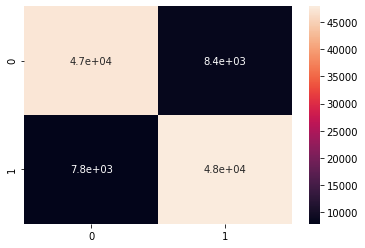

In [47]:
model_test = model_load(config, 
                        BinGCNConv(config.NUM_FEATURES, config.N_CLASSES).to(device),
                        name=result_name,
                       )
y_true, y_pred, y_prob = test(config, train_loader, model_test)

In [48]:
report = classification_report(y_true, y_pred)

# write the report
write_log("\n{}\n\n{}\n".\
          format("=== Classification Report ===",
                 report
                ),
          config.log_file,
          "a+")

# print
# print(report)


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85     55760
         1.0       0.85      0.86      0.86     55760

    accuracy                           0.85    111520
   macro avg       0.85      0.85      0.85    111520
weighted avg       0.85      0.85      0.85    111520




### 8-2. Saving Testing Result

In [52]:
config.PREDICTED_RESULT = os.path.join("result/graph/prediction", "{}.pkl".format(result_name))

In [46]:
# saving predicted result
with open(config.PREDICTED_RESULT, 'wb') as f:
    pickle.dump([y_true, y_pred, y_prob], f)

In [53]:
with open(config.PREDICTED_RESULT, 'rb') as f:
    y_true, y_pred, y_prob = pickle.load(f)

## 9. Learning Curve

read the log file for the train loss and the val loss.

In [54]:
config.log_file = os.path.join(config.log_path, "{}.txt".format(result_name))
with open(config.log_file, "r+") as file:
    logs = file.readlines()
    val_loss = []
    train_loss = []
    for row in logs:
        if len(row.split("|")) < 2:
            continue
        else:
            train_loss.append(float(row.split("|")[-2].strip().split(" ")[-1]))
            val_loss.append(float(row.split("|")[-1].strip().split(" ")[-1]))
    assert len(train_loss) == len(val_loss)

draw the learning curve below.

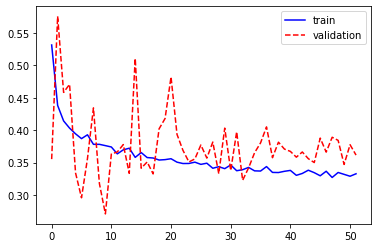

In [51]:
fig, ax = plt.subplots()
ax.plot(range(len(train_loss)), train_loss, '-b', label='train')
ax.plot(range(len(val_loss)), val_loss, '--r', label='validation')
leg = ax.legend();

## 10. Length Difference

In [52]:
# seed_torch(config.SEED)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_word_length = []
for batch in tqdm(test_loader):
#     nodes_count = sorted(Counter(batch.batch.data.numpy()).items(), key=lambda x: x[0])
    x = batch.batch.data.numpy()
    unique, counts = np.unique(x, return_counts=True)
    test_word_length += list(counts)

/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


### 10-2. Saving/Reloading Length Information

In [53]:
assert len(y_prob) == len(test_word_length)
with open(os.path.join("dataset/token_length/", "testloader_seed_{}.pkl".format(config.SEED)), 'wb') as f:
    pickle.dump(test_word_length, f)

In [55]:
with open(os.path.join("dataset/token_length/", "testloader_seed_{}.pkl".format(config.SEED)), 'rb') as f:
    test_word_length_reloaded = pickle.load(f)

### 10-3. Plot: Length vs. Correctness

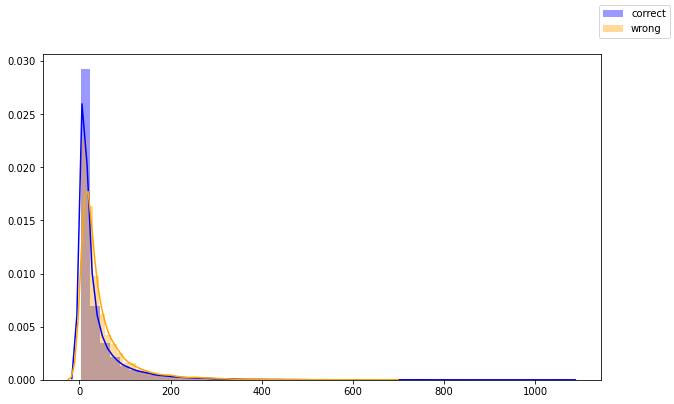

In [56]:
compared_result = [y_pred[i] == y_true[i] for i in range(len(y_true))]
correct_word_length = [test_word_length_reloaded[idx] for idx, value in enumerate(compared_result) if value == True] # the word length list of the sample which is predicted correctly
wrong_word_length = [test_word_length_reloaded[idx] for idx, value in enumerate(compared_result) if value == False]

fig = plt.figure(figsize=(10,6))
sns.distplot(correct_word_length, color="blue")
sns.distplot(wrong_word_length, color="orange")
fig.legend(labels=["correct", "wrong"])
plt.show()

> From the plot above, I found that the length of words (tokens) may not affect the prediction result. The distribution looks quite similar.

## 11. Score in 5 Group vs. Accuracy

I am interested in the prediction of the review with an original overall score from 1 to 5.

In [57]:
def score_5_acc(score=3, labels=test_df["overall"], compared_result=compared_result):
    labels = list(labels)
    selected_comared_result = [res for idx, res in enumerate(compared_result) if labels[idx] == score]
    return round(sum(selected_comared_result) / len(selected_comared_result)*100, 2)

# compared_result = [y_pred[i] == y_true[i] for i in range(len(y_true))]
for i in range(1, 6):
    print("Overall Scoree {}: {}%".format(i, score_5_acc(score=i,
                                                         labels=test_df["overall"],
                                                         compared_result=compared_result)))

Overall Scoree 1: 89.41%
Overall Scoree 2: 76.2%
Overall Scoree 3: 52.03%
Overall Scoree 4: 79.83%
Overall Scoree 5: 90.79%


## 13. TextBlob

In [58]:
sentiment_scores = [1 if TextBlob(text).sentiment.polarity >= 0 else 0 for text in tqdm(test_df["reviewText"])]

/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [62]:
sum(sentiment_scores == test_df["y"]) / test_df.shape[0]

0.8607097191096201

=== Confusion Matrix ===
      0      1
0  3409   3577
1  6554  59193

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.34      0.49      0.40      6986
           1       0.94      0.90      0.92     65747

    accuracy                           0.86     72733
   macro avg       0.64      0.69      0.66     72733
weighted avg       0.89      0.86      0.87     72733




<AxesSubplot:>

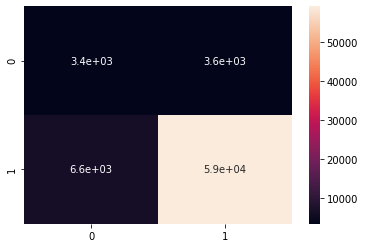

In [61]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df["y"], sentiment_scores))
print("{}\n{}\n".format("=== Confusion Matrix ===", confusion_matrix_df))
report = classification_report(test_df["y"], sentiment_scores)
print("{}\n{}\n".format("=== Classification Report ===",report))
# plot
sns.heatmap(confusion_matrix_df, annot=True)

**What's the distribution of sentiment.polarity?**

In [63]:
sentiment_polarity = [TextBlob(text).sentiment.polarity for text in tqdm(test_df["reviewText"])]


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'TextBlob')

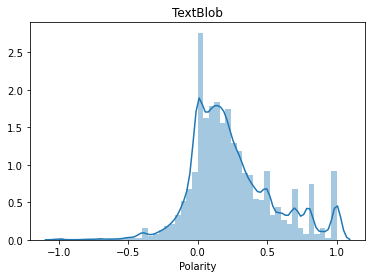

In [65]:
sns.distplot(sentiment_polarity)
plt.xlabel("Polarity")
plt.title("TextBlob")

> From above, The distribution of predicted sentiment polarity from textblob does not really match the distribution of the true overall score.

> On the other hand, my neural network prediction looks much better, compared to the true situation.

In [66]:
result_name

'neighbor5_GCN_2020_08_23_15_12_version1'

Text(0.5, 1.0, 'neighbor5 GCN')

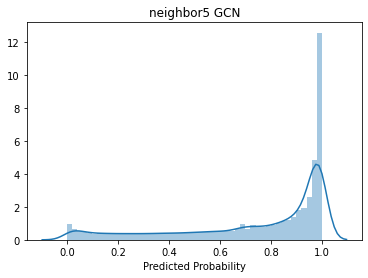

In [67]:
sns.distplot(y_prob)
plt.xlabel("Predicted Probability")
plt.title(" ".join(result_name.split("_")[:2]))

**What about changing sentiment scores to 1~5?**

I can already guess the result would be terrible from the plots above.

In [54]:
def rescale_sentiment(score):
    '''
    @param scores: a sentiment score
    [-1, 1] -> [1,2,3,4,5]
    '''
    if -1 <= score < -0.6:
        return 1
    elif -0.6 <= score < -0.2:
        return 2
    elif -0.2 <= score < 0.2:
        return 3
    elif 0.2 <= score < 0.6:
        return 4
    elif 0.6 <= score <= 1:
        return 5

In [ ]:
def score_5_acc(score=3, labels=test_df["overall"], compared_result=compared_result):
    labels = list(labels)
    selected_comared_result = [res for idx, res in enumerate(compared_result) if labels[idx] == score]
    return round(sum(selected_comared_result) / len(selected_comared_result)*100, 2)

In [58]:
rescaled_sentiment_scores = [rescale_sentiment(TextBlob(text).sentiment.polarity) for text in tqdm(test_df["reviewText"])]

/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [59]:
compared_result = [rescaled_sentiment_scores[i] == test_df["overall"][i] for i in range(test_df.shape[0])]
for i in range(1, 6):
    print("Overall Scoree {}: {}%".format(i, score_5_acc(score=i,
                                                         labels=test_df["overall"],
                                                         compared_result=compared_result)))

Overall Scoree 1: 3.06%
Overall Scoree 2: 9.02%
Overall Scoree 3: 71.61%
Overall Scoree 4: 30.47%
Overall Scoree 5: 19.9%


**What about changing sentiment scores to negative, neutral, and positive?**

In [71]:
compared_result_3_classes = []
for i in range(len(y_true)):
    if rescaled_sentiment_scores[i] < 3 and y_true[i] < 3:
        # negative: 1,2
        compared_result_3_classes.append(True)
    elif rescaled_sentiment_scores[i] == 3 and y_true[i] == 3:
        # neutral
        compared_result_3_classes.append(True)
    elif rescaled_sentiment_scores[i] > 3 and y_true[i] > 3:
        # negative: 4,5
        compared_result_3_classes.append(True)
    else:
        # does not match
        compared_result_3_classes.append(False)

In [72]:
for i in range(1, 6):
    print("Overall Scoree {}: {}%".format(i, score_5_acc(score=i,
                                                         labels=test_df["overall"],
                                                         compared_result=compared_result_3_classes)))

Overall Scoree 1: 21.17%
Overall Scoree 2: 9.62%
Overall Scoree 3: 4.14%
Overall Scoree 4: 1.53%
Overall Scoree 5: 1.24%


## 14. Model + TextBlob

In [ ]:
sentiment_scores

## 14. Rename Logs and Checkpoints

In [46]:
# new_predicted_result = config.PREDICTED_RESULT.split(".")[0] + "_version{}.".format(1) + config.PREDICTED_RESULT.split(".")[1]
# new_log_file = config.log_file.split(".")[0] + "_version{}.".format(1) + config.log_file.split(".")[1]
# new_best_model = config.best_model.split(".")[0] + "_version{}.".format(1) + config.best_model.split(".")[1]

In [50]:
# os.rename(config.PREDICTED_RESULT, new_predicted_result)